In [ ]:
!conda config --add channels conda-forge
!conda install -y fenics

# Eigenvalue solver

In [ ]:
from fenics import *
from dolfin import *
import math
import numpy as np
    
moduli = [70e9]    

# Create n different materials
class K(Expression):
    def set_k_values(self, k_array):
        self.k_array = k_array
    def eval(self, value, x):
        # Cantilever is split into n materials serially along length
        index = math.floor(x[0]*len(self.k_array))
        value[0] = self.k_array[int(index)]

# Initialize kappa
kappa = K(degree=0)
kappa.set_k_values(moduli)

# Scaled variables
L = 1 # Length
W = 0.02 # Width

Young = kappa
poisson = 0.3

lambda_ = Young * poisson / ((1 + poisson) * (1 - 2*poisson))
mu = Young / (2 * (1 + poisson))

rho = 2700

# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 100, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
#f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
#L = dot(f, v)*dx + dot(T, v)*ds

# Assemble stiffness form
A = PETScMatrix()
assemble(a, tensor=A)

# Create eigensolver
eigensolver = SLEPcEigenSolver(A)

# Compute all eigenvalues of A x = \lambda x
print("Computing eigenvalues. This can take a minute.")
eigensolver.parameters['spectrum'] = 'smallest magnitude'
eigensolver.solve(15)
eigensolver.get_number_converged()

# Extract largest (first) eigenpair
eigens = []
for i in range(15):
    eigens.append(eigensolver.get_eigenpair(i))
    
for i in range(len(eigens)):
    print("Eigenvalue", i, ": ", eigens[i][0], " | Frequency", i, ": ", np.sqrt(eigens[i][0]))

# Displacement

In [20]:
"""
FEniCS tutorial demo program: Linear elastic problem.

  -div(sigma(u)) = f

The model is used to simulate an elastic beam clamped at
its left end and deformed under its own weight.
"""

from fenics import *
from dolfin import *
import math
import numpy as np

def run_solver(moduli):
    
    # Create n different materials
    class K(Expression):
        def set_k_values(self, k_array):
            self.k_array = k_array
        def eval(self, value, x):
            # Cantilever is split into n materials serially along length
            index = math.floor(x[0]*len(self.k_array))
            value[0] = self.k_array[int(index)]
            
    # Initialize kappa
    kappa = K(degree=0)
    kappa.set_k_values(moduli)
    
    # Scaled variables
    L = 1 # Length
    W = 0.2 # Width
    
    Young = kappa
    poisson = 0.3
    
    lambda_ = Young * poisson / ((1 + poisson) * (1 - 2*poisson))
    mu = Young / (2 * (1 + poisson))
    
    rho = 2.7e3
    g = 9.8
    
    # Create mesh and define function space
    mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 100, 3, 3)
    V = VectorFunctionSpace(mesh, 'P', 1)
    
    # Define boundary condition
    tol = 1E-14
    
    def clamped_boundary(x, on_boundary):
        return on_boundary and x[0] < tol
    
    bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)
    
    # Define strain and stress
    def epsilon(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
        #return sym(nabla_grad(u))
    
    def sigma(u):
        return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)
    
    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()  # space dimension
    v = TestFunction(V)
    f = Constant((0, 0, -rho*g))
    T = Constant((0, 0, 0))
    a = inner(sigma(u), epsilon(v))*dx
    L = dot(f, v)*dx + dot(T, v)*ds
    
    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    
    # Save solution
    #vtkfile = File('poisson/solution.pvd')
    #vtkfile << u
    
    # Compute magnitude of displacement
    V = FunctionSpace(mesh, 'P', 1)
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, V)
    #plot(u_magnitude, 'Displacement magnitude')
    #print('min/max u:',
    #      u_magnitude.vector().get_local().min(),
    #      u_magnitude.vector().get_local().max())
    #import matplotlib
    vertical = u_magnitude.vector().get_local()[::4]
    #matplotlib.pyplot.plot(-vertical)
    
    return vertical


def get_fitness(moduli, target):
    deflections = run_solver(moduli)
    interestPoints = [deflections[0], deflections[100], deflections[200], deflections[300], deflections[400]]
    differences = np.subtract(interestPoints, target)
    fitness = np.linalg.norm(differences)
    
    return fitness

In [5]:
deflections = run_solver([1e6, 1e7, 1e8, 1e7, 1e6])

print(deflections[0])
print(deflections[100])
print(deflections[200])
print(deflections[300])
print(deflections[400])

import matplotlib.pyplot as plt
plt.plot(-deflections)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-5.89504728071e-06
0.0908443021264
0.206902659139
0.330447429145
0.460917666377


#### Displacement (binary material)

In [11]:
"""
FEniCS tutorial demo program: Linear elastic problem.

  -div(sigma(u)) = f

The model is used to simulate an elastic beam clamped at
its left end and deformed under its own weight.
"""

from fenics import *
from dolfin import *
import math
import numpy as np

def run_solver_binary(moduli):
    
    moduli_array = [1e6, 1e8]
    
    # Create n different materials
    class K(Expression):
        def set_k_values(self, k_array):
            self.k_array = k_array
        def eval(self, value, x):
            # Cantilever is split into n materials serially along length
            index = math.floor(x[0]*len(self.k_array))
            value[0] = self.k_array[int(index)]
            
    # Initialize kappa
    kappa = K(degree=0)
    kappa.set_k_values([moduli_array[x] for x in moduli])
    
    # Scaled variables
    L = 1 # Length
    W = 0.2 # Width
    
    Young = kappa
    poisson = 0.3
    
    lambda_ = Young * poisson / ((1 + poisson) * (1 - 2*poisson))
    mu = Young / (2 * (1 + poisson))
    
    rho = 2.7e3
    g = 9.8
    
    # Create mesh and define function space
    mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 100, 3, 3)
    V = VectorFunctionSpace(mesh, 'P', 1)
    
    # Define boundary condition
    tol = 1E-14
    
    def clamped_boundary(x, on_boundary):
        return on_boundary and x[0] < tol
    
    bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)
    
    # Define strain and stress
    def epsilon(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
        #return sym(nabla_grad(u))
    
    def sigma(u):
        return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)
    
    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()  # space dimension
    v = TestFunction(V)
    f = Constant((0, 0, -rho*g))
    T = Constant((0, 0, 0))
    a = inner(sigma(u), epsilon(v))*dx
    L = dot(f, v)*dx + dot(T, v)*ds
    
    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    
    # Save solution
    #vtkfile = File('poisson/solution.pvd')
    #vtkfile << u
    
    # Compute magnitude of displacement
    V = FunctionSpace(mesh, 'P', 1)
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, V)
    #plot(u_magnitude, 'Displacement magnitude')
    #print('min/max u:',
    #      u_magnitude.vector().get_local().min(),
    #      u_magnitude.vector().get_local().max())
    #import matplotlib
    vertical = u_magnitude.vector().get_local()[::4]
    #matplotlib.pyplot.plot(-vertical)
    
    return vertical


def get_fitness_binary(moduli, target):
    deflections = run_solver_binary(moduli)
    interestPoints = [deflections[0], deflections[100], deflections[200], deflections[300], deflections[400]]
    differences = np.subtract(interestPoints, target)
    fitness = np.linalg.norm(differences)
    
    return fitness

-5.99702377642e-08
0.000999417416962
0.0563692217035
0.148797269843
0.249195328154


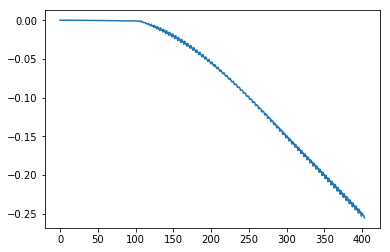

In [40]:
deflections = run_solver([1, 0, 0, 1])

print(deflections[0])
print(deflections[100])
print(deflections[200])
print(deflections[300])
print(deflections[400])

import matplotlib.pyplot as plt
plt.plot(-deflections)

# Heuristics

In [14]:
# Presolved target
def get_fitness_wrapper(moduli):
    target = [0, 0.09, 0.20, 0.33, 0.46]
    
    return get_fitness(moduli, target)

# Presolved target
def get_fitness_wrapper_binary(moduli):
    target = [0, 0.09, 0.20, 0.33, 0.46]
    
    return get_fitness_binary(moduli, target)

import time
start = time.time()
fitness = get_fitness_wrapper([1e6, 1e7, 1e8, 1e7, 1e6])
end = time.time()
print("Time taken =", end - start, "seconds")

print("Fitness =", fitness)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time taken = 5.366480827331543 seconds
Fitness = 0.00702864769683


### SciPy heuristics

In [15]:
import scipy.optimize

bounds = [(1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8)]
bounds_tuple = ((1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8), (1e6, 1e8))

np.set_printoptions(formatter={'float': lambda x: format(x, '.2E')})

#### Differential evolution

In [57]:
solution = scipy.optimize.differential_evolution(get_fitness_wrapper, bounds, maxiter=10, popsize=15)

print("Solution =", solution.x)
print("Objective function (min) =", solution.fun)
print("Function evaluations =", solution.nfev)

Solution = [1.08E+06 7.68E+06 5.01E+06 5.74E+07 1.97E+07]
Objective function (min) = 0.0189115978951
Function evaluations = 897


#### Basin hopping

In [ ]:
# ???
solution = scipy.optimize.basinhopping(get_fitness_wrapper, x0 = [1e7, 1e7, 1e7, 1e7, 1e7], niter=3, T= 0.1, stepsize= 1e6)

print("Solution =", solution.x)
print("Objective function (min) =", solution.fun)
print("Function evaluations =", solution.nfev)

#### Brute force

In [55]:
gridpoints = 4

solution = scipy.optimize.brute(get_fitness_wrapper, ranges = bounds_tuple, Ns = gridpoints, full_output=True, finish=None)

print("Solution =", solution[0])
print("Objective function (min) =", solution[1])
print("Function evaluations =", gridpoints**5)

Solution = [1.00E+06 3.40E+07 3.40E+07 1.00E+06 1.00E+08]
Objective function (min) = 0.00431771909604
Function evaluations = 1024


### DEAP heuristics

In [ ]:
!pip install deap

In [21]:
import multiprocessing

import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

toolbox.register("attr_float", random.uniform, 1e6, 1e8)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return get_fitness_wrapper(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1e6, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
    
pop = toolbox.population(n=15)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=100, 
                               stats=stats, halloffame=hof, verbose=False)

print(log)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std        	min      	max      
0  	15    	0.558998 	0.0344194  	0.452143 	0.589891 
1  	6     	0.508059 	0.0486482  	0.452135 	0.573023 
2  	13    	0.47219  	0.0469959  	0.373284 	0.591114 
3  	9     	0.431368 	0.0350395  	0.373284 	0.456033 
4  	8     	0.410056 	0.0393108  	0.373284 	0.452143 
5  	8     	0.371409 	0.00559982 	0.351231 	0.373284 
6  	11    	0.369607 	0.0121503  	0.351231 	0.402446 
7  	9     	0.367135 	0.0168539  	0.351231 	0.40972  
8  	6     	0.356967 	0.00821737 	0.351231 	0.373284 
9  	8     	0.351547 	0.00503392 	0.339971 	0.367194 
10 	9     	0.350481 	0.00280883 	0.339971 	0.351231 
11 	9     	0.348978 	0.00450387 	0.33997  	0.351231 
12 	7     	0.342974 	0.00497893 	0.33997  	0.351231 
13 	10    	0.338896 	0.00402232 	0.323845 	0.339972 
14 	12    	0.33567  	0.00713066 	0.323845 	0.339971 
15 	8     	0.330295 	0.00789939 	0.323845 	0.33997  
16 	11    	0.32618  	0.00598417 	0.323795 	0.342791 
17 	11    	0.323839 	1.70466e-05	0.323795 	0.3

Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/nbuser/anaconda3_501/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/h

In [18]:
import array
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 1000)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return get_fitness_wrapper_binary(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
    
pop = toolbox.population(n=15)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=100, 
                               stats=stats, halloffame=hof, verbose=False)

print(log)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


gen	nevals	avg      	std       	min      	max      
0  	15    	0.434249 	0.03494   	0.371606 	0.519972 
1  	7     	0.410397 	0.0285824 	0.371606 	0.459556 
2  	10    	0.385787 	0.0137199 	0.367699 	0.405667 
3  	10    	0.376268 	0.0196575 	0.324349 	0.404183 
4  	10    	0.368458 	0.0162866 	0.326163 	0.404248 
5  	10    	0.353092 	0.0235832 	0.315531 	0.397781 
6  	8     	0.339848 	0.0315853 	0.292618 	0.420199 
7  	8     	0.319381 	0.019107  	0.292618 	0.358691 
8  	11    	0.311231 	0.026969  	0.2723   	0.373524 
9  	9     	0.293624 	0.0200815 	0.270765 	0.3326   
10 	11    	0.286087 	0.0190502 	0.270569 	0.324779 
11 	8     	0.270778 	0.0112123 	0.237841 	0.292056 
12 	9     	0.276463 	0.0318293 	0.235725 	0.352789 
13 	11    	0.260014 	0.029575  	0.201898 	0.331326 
14 	13    	0.24882  	0.0266176 	0.193713 	0.292529 
15 	4     	0.227902 	0.0281947 	0.179113 	0.300034 
16 	12    	0.215613 	0.0255731 	0.179113 	0.281924 
17 	7     	0.210633 	0.0340303 	0.179113 	0.301694 
18 	11    	0

### PyGMO

In [ ]:
!pip install pygmo

In [65]:
import pygmo as pg

class beam_function:
    def __init__(self, dim):
        self.dim = dim
    
    def fitness(self, x):
        return [get_fitness_wrapper(x)]
    
    def get_bounds(self):
        return ([1e6] * self.dim, [1e8] * self.dim)
    
    def get_name(self):
        return "Beam Function"
    
    def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)
    
class beam_function_binary:
    def __init__(self, dim):
        self.dim = dim
    
    def fitness(self, x):
        return [get_fitness_wrapper_binary(x)]
    
    def get_bounds(self):
        return ([0] * self.dim, [1] * self.dim)
    
    def get_name(self):
        return "Beam Function"
    
    def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)
    
    def get_nix(self):
        return 3

In [67]:
prob = pg.problem(beam_function(5))

algo = pg.algorithm(pg.sga(gen = 100))
pop = pg.population(prob,15)
pop = algo.evolve(pop)
print(pop.champion_x, pop.champion_f) 

[1.19E+06 2.46E+06 1.72E+07 1.72E+07 9.78E+07] [1.15E-02]


In [ ]:
# Not working yet
prob = pg.problem(beam_function_binary(3))

algo = pg.algorithm(pg.sga(gen = 20))
pop = pg.population(prob,10)
pop = algo.evolve(pop)
print(pop.champion_x, pop.champion_f, prob.get_fevals()) 

In [72]:
# Not sure about number of function evaluations
prob = pg.problem(beam_function(5))

algo = pg.algorithm(pg.simulated_annealing())
pop = pg.population(prob,15)
pop = algo.evolve(pop)
print(pop.champion_x, pop.champion_f) 

[1.17E+06 3.62E+07 7.97E+07 8.32E+07 4.10E+07] [1.06E-01]


In [68]:
prob = pg.problem(beam_function(5))

algo = pg.algorithm(pg.de(gen = 100))
pop = pg.population(prob,15)
pop = algo.evolve(pop)
print(pop.champion_x, pop.champion_f) 

[1.01E+06 6.22E+07 2.84E+06 2.33E+07 5.81E+07] [2.04E-03]


In [74]:
prob = pg.problem(beam_function(5))

algo = pg.algorithm(pg.pso(gen = 100))
pop = pg.population(prob,15)
pop = algo.evolve(pop)
print(pop.champion_x, pop.champion_f) 

[1.00E+06 9.95E+07 3.24E+06 3.09E+07 9.63E+06] [2.59E-03]
